In [7]:
import sys
sys.path.insert(0, './..')
sys.path.insert(0, '../data')

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import proplot as pplt
import numpy as np
import plots as pl
import tqdm
import torch
from torchvision import datasets, transforms
from robustness.datasets import CIFAR
import dill
import pickle5 as pickle
from utils import dev, load_data, classification, make_orth_basis, orth_check

from models import eval, model
from matplotlib.ticker import FormatStrFormatter
import tqdm
from scipy.stats import kstest, multivariate_normal
import seaborn as sns
titlesize = 10
fontsize = 8
cm = 1/2.54
figwidth = 13.968*cm
dpi = 600
params = {'legend.fontsize': fontsize,
          'legend.title_fontsize': fontsize,
          'font.family': 'serif',
         'axes.labelsize': fontsize,
         'axes.titlesize':titlesize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
plt.rcParams.update(params)

def tab_name_to_hex(tab): 
    conv_table = {
        "tab:blue": "#1f77b4",
        "tab:orange": "#ff7f0e",
        "tab:green": "#2ca02c",
        "tab:red": "#d62728",
        "tab:purple": "#9467bd",
        "tab:brown": "#8c564b",
        "tab:pink": "#e377c2",
        "tab:gray": "#7f7f7f",
        "tab:grey": "#7f7f7f",
        "tab:olive": "#bcbd22",
        "tab:cyan": "#17becf",
    }
    return conv_table[tab.lower()]

plot_colors = [tab_name_to_hex('tab:blue'), tab_name_to_hex('tab:red')]

# Load models

In [3]:
ds = CIFAR('../data/cifar-10-batches-py')
classifier_model = ds.get_model('resnet50', False)
model_natural = model.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_models/cifar_nat.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]: v for k, v in sd.items()}
model_natural.load_state_dict(sd)
model_natural.to(dev())
model_natural.double()
model_natural.eval()

classifier_model = ds.get_model('resnet50', False)
model_robust = model.cifar_pretrained(classifier_model, ds)

resume_path = '../models/cifar_models/cifar_l2_0_5.pt'
checkpoint = torch.load(resume_path, pickle_module=dill, map_location=torch.device(dev()))

state_dict_path = 'model'
if not ('model' in checkpoint):
    state_dict_path = 'state_dict'
sd = checkpoint[state_dict_path]
sd = {k[len('module.'):]:v for k,v in sd.items()}
model_robust.load_state_dict(sd)
model_robust.to(dev())
model_robust.double()
model_robust.eval()

cifar_pretrained(
  (normalizer): InputNormalize()
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): SequentialWithArgs(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05,

# Load data

In [4]:
# load data
data_nat = np.load('../data/cifar_natural_diff.npy', allow_pickle=True).item()
advs = data_nat['advs']
pert_lengths = data_nat['pert_lengths']
classes = data_nat['adv_class']
dirs = data_nat['dirs']
images = data_nat['images']
labels = data_nat['labels']
pert_lengths = data_nat['pert_lengths']

data_madry = np.load('../data/cifar_robust_diff.npy', allow_pickle=True).item()
images_madry = data_madry['images']
labels_madry = data_madry['labels']
advs_madry = data_madry['advs']
pert_lengths_madry = data_madry['pert_lengths']
classes_madry = data_madry['adv_class']
dirs_madry = data_madry['dirs']

cifar_labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot grid of adversarial examples

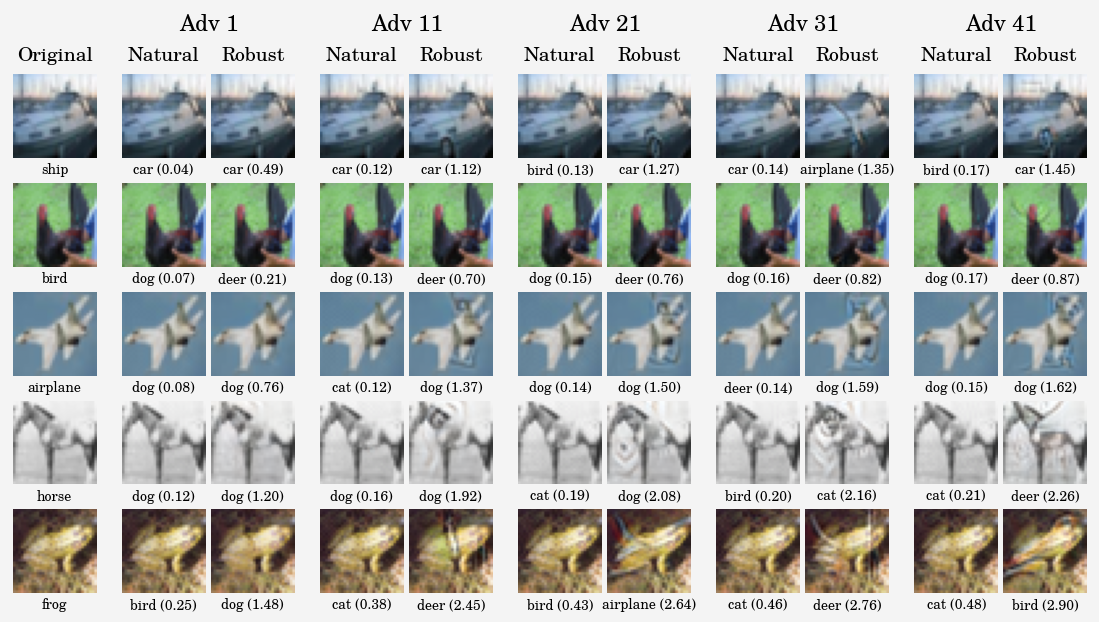

In [124]:
array = [
    range(1,12),
    range(12,23),
    range(23,34),
    range(34,45),
    range(45,56)
]
hspace = [1,]*4
wspace =  [1, 0.2,]*5
n_images = 5

fig, ax = pplt.subplots(array, sharey=False, sharex=False, dpi=100,
                          wspace=wspace, hspace=hspace, figwidth=figwidth, top=3)

img_idcs = [81, 20, 1 ,77, 63]
# img_idcs = np.random.choice(np.arange(100), size=n_images, replace=False)

ax[0].set_title('Original', fontsize=7)
ax_idx=0
for i, img_n in enumerate(img_idcs):
    ax[ax_idx].imshow(np.transpose(images[img_n].reshape((3,32,32)), (1,2,0)))
    ax[ax_idx].set_xlabel(cifar_labels[int(labels[img_n])], fontsize=5)
    ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    for pos in ['top', 'left', 'right', 'bottom']:
        ax[ax_idx].spines[pos].set_visible(False)

    ax_idx+=1
    for j in range(n_images):
        ax[ax_idx].imshow(np.transpose(advs[img_n,j*10].reshape((3,32,32)), (1,2,0)))
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
#         ax[ax_idx].set_xlabel(cifar_labels[int(classes[img_n,j*10])]+ ', $\ell_2$=%.2f' % (pert_lengths[img_n, j*10]), fontsize=4)
        ax[ax_idx].set_xlabel(cifar_labels[int(classes[img_n,j*10])]+ ' (%.2f)' % (pert_lengths[img_n, j*10]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        if i == 0:
            ax[ax_idx].set_title('Natural', fontsize=7)
        
        ax_idx+=1
        if i == 0:
            ax[ax_idx].set_title('Robust', fontsize=7)
        ax[ax_idx].imshow(np.transpose(advs_madry[img_n,j*10].reshape((3,32,32)), (1,2,0)))
        ax[ax_idx].set_xticks([])
        ax[ax_idx].set_yticks([])
        for pos in ['top', 'left', 'right', 'bottom']:
            ax[ax_idx].spines[pos].set_visible(False)
        ax[ax_idx].set_xlabel(cifar_labels[int(classes_madry[img_n,j*10])]+ ' (%.2f)' % (pert_lengths_madry[img_n, j*10]), fontsize=5)
        ax[ax_idx].xaxis.set_label_coords(0.5, -0.05)
        ax_idx+=1

# the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
plt.figtext(.19,.96,"Adv 1", va="center", ha="center", size=8)
plt.figtext(.37,.96,"Adv 11", va="center", ha="center", size=8)
plt.figtext(.55,.96,"Adv 21", va="center", ha="center", size=8)
plt.figtext(.73,.96,"Adv 31", va="center", ha="center", size=8)
plt.figtext(.91,.96,"Adv 41", va="center", ha="center", size=8)

fig.savefig('../figures/cifar_examples.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)


# Perturbation Length comparison

In [129]:
def plot_boxplot(pert_lengths, n=10, labels=None, showmeans=False, ax=None):
    n = np.minimum(n, pert_lengths[0].shape[1])
    pert_lengths = [p[:,:n] for p in pert_lengths]
    colors = plot_colors
    l = []
    offset = [-.4,.4]
    

    for i, pl in enumerate(pert_lengths):
        boxprops = dict(color=colors[i], linewidth=.5, alpha=1)
        whiskerprops = dict(color=colors[i], alpha=0.7)
        capprops = dict(color=colors[i], alpha=0.7)
        medianprops = dict(linestyle='--', linewidth=.5, color=colors[i])
        meanprops = dict(linestyle='-', linewidth=.5, color=colors[i])


        if not labels is None:
            l.append(mpatches.Patch(color=colors[i], label=labels[i]))

        pl[pl==0] = np.nan
        mask = ~np.isnan(pl)
        filtered_data = [d[m] for d, m in zip(pl.T, mask.T)]
        ax.boxplot(filtered_data, positions=np.array(range(len(filtered_data)))*len(pert_lengths) + offset[i], sym='', widths=0.6,
                   whis=[10,90], showfliers=False, meanline=showmeans, showmeans=showmeans, boxprops=boxprops, 
                   whiskerprops=whiskerprops, capprops=capprops, meanprops=meanprops,  medianprops=medianprops)
#     ax.set_title('Perturbation length of first ' + str(n) + ' adversarial directions')
    ax.set_xlabel('dimension')
    ax.set_ylabel('adversarial vector length')
    ax.set_xticks(np.arange(0,n*len(pert_lengths),5*len(pert_lengths)))
    ax.set_xticklabels(np.arange(1,n+1,5))
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.xaxis.grid(False)
    if not (labels is None):
        leg = ax.legend(handles=l, frameon=False)
        leg.get_frame().set_linewidth(0.0)
    return 

In [31]:
epsilons = np.arange(0,4,.001)
n_dims_natural = np.zeros((len(epsilons),len(images)))
n_dims_robust = np.zeros((len(epsilons),len(pert_lengths_madry[pert_lengths_madry[:,0]>0])))
for i, e in enumerate(epsilons):
    n_dims_natural[i,:len(classes)] = (pert_lengths < e).sum(-1)
    n_dims_robust[i] = (pert_lengths_madry[pert_lengths_madry[:,0]>0] < e).sum(-1)

percentiles_natural = np.percentile(n_dims_natural, [10,90], axis=-1)
means_natural = np.mean(n_dims_natural,axis=-1)
errors_natural = percentiles_natural.copy()
errors_natural[0] = means_natural-percentiles_natural[0]
errors_natural[1] = percentiles_natural[1] - means_natural

percentiles_robust = np.percentile(n_dims_robust, [10,90], axis=-1)
means_robust = np.mean(n_dims_robust,axis=-1)
errors_robust = percentiles_robust.copy()
errors_robust[0] = means_robust-percentiles_robust[0]
errors_robust[1] = percentiles_robust[1] - means_robust

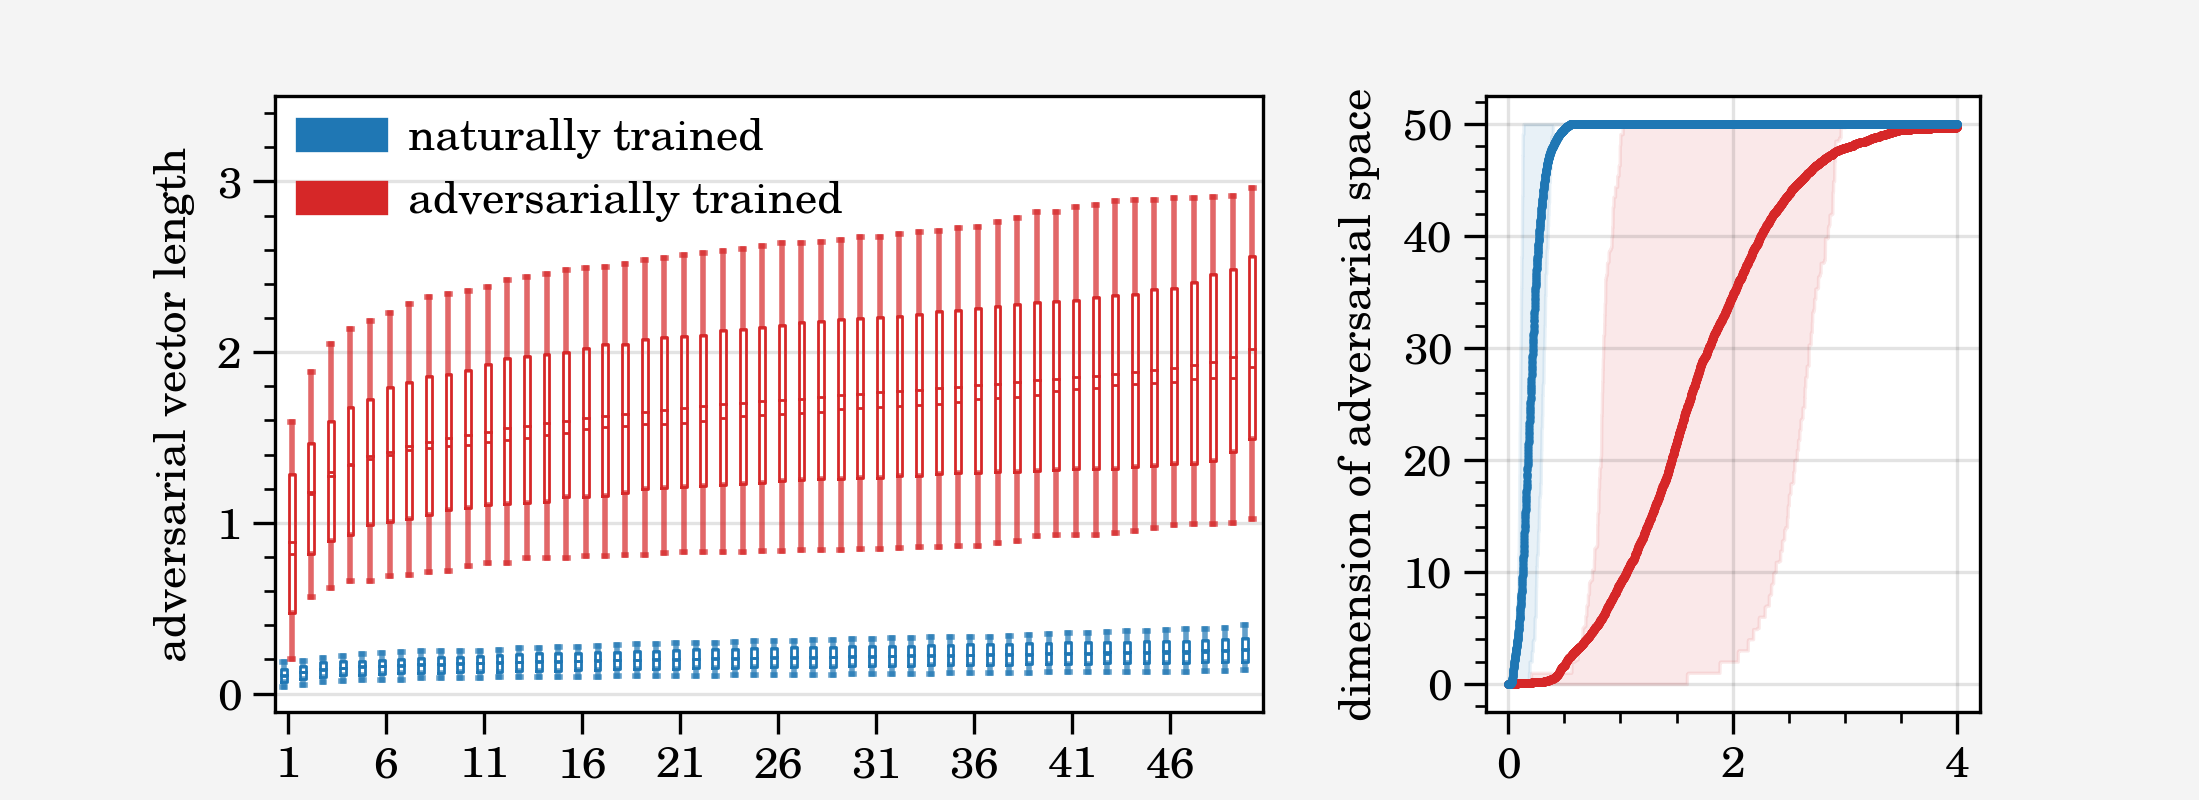

In [130]:

fig, axs = plt.subplots(1,2, figsize=(figwidth, 2), dpi=200, gridspec_kw={'width_ratios': [2,1]})
### only samples with at least n adversarials included
n=50

        
# plot with all adversarials included
plot_boxplot([pert_lengths,pert_lengths_madry],  n=n, labels=['naturally trained','adversarially trained'], ax=axs[0], showmeans=True)
axs[0].set_ylim(top=3.5)
axs[0].set_xlim(-1.3,99.5)


axs[1].plot(epsilons, means_robust,'.', markersize=1,color=plot_colors[1],  label='robust')
axs[1].fill_between(epsilons, (means_robust-errors_robust[0]), (means_robust+errors_robust[1]), color=plot_colors[1], alpha=.1)
axs[1].plot(epsilons, means_natural,'.', markersize=1, color=plot_colors[0],   label='natural')
axs[1].fill_between(epsilons, (means_natural-errors_natural[0]), (means_natural+errors_natural[1]), color=plot_colors[0], alpha=.1)
axs[1].set_ylabel('dimension of adversarial space')
axs[1].set_xlabel('distance to decision boundary')
fig.subplots_adjust(wspace=.3)

fig.savefig('../figures/pert_lengths.pdf', dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

# Distance to decision boundary

In [4]:
def get_dist_dec(orig, label, dirs, model, min_dist=.1, n_samples=1000, return_angles=False):
    shape = orig.shape
    n_steps = 20
    n_dirs = len(dirs)
    dirs = dirs.reshape((n_dirs, -1))

    upper = np.full((n_samples, 1), np.inf) 
    lower = np.ones((n_samples, 1)) * min_dist

    scales = np.ones((n_samples, 1)) * min_dist

    coeffs = abs(np.random.normal(size=[n_samples, n_dirs]))
    sample_dirs = (coeffs @ dirs)
    sample_dirs = sample_dirs / np.linalg.norm(sample_dirs, axis=-1, keepdims=True)

    dists = np.full(n_samples, np.nan)

    for i in range(n_steps):
        input_dirs = scales * sample_dirs
        input_ = (input_dirs + orig.flatten()[None])
        input = torch.split(torch.tensor(input_.reshape((-1,) + shape), device=dev()), 100)

        preds = np.empty(0)
        for batch in input:
            preds = np.concatenate((preds, model(batch).argmax(-1).cpu().numpy()), axis=0)

        is_adv = np.invert(preds == label)
        dists[is_adv] = scales[is_adv, 0]

        upper[is_adv] = scales[is_adv]
        lower[~is_adv] = scales[~is_adv]
        scales[is_adv] = (upper[is_adv] + lower[is_adv]) / 2
        scales[~is_adv] = lower[~is_adv] * 2

        in_bounds = np.logical_or(input_.max(-1) <= 1, input_.min(-1) >= 0)
        dists[~in_bounds] = np.nan

    if return_angles:
        angles = np.arccos((sample_dirs@dirs.T).clip(-1,1)).min(-1)
        angles[np.isnan(dists)] = np.nan
        return dists, angles
    return dists

def get_mean_dist(orig, model, n_sample_dirs=100):
    shape = orig.shape
    dists = np.zeros(n_sample_dirs)
        
    # generate n random unitary vectors
    dirs = np.random.uniform(size=(n_sample_dirs,len(orig.flatten()))) - orig.flatten()
    
    for i, d in enumerate(dirs):
        dists[i] = get_dist(orig, d, model_, delta)
        
    mean_dist = np.nanmean(dists)
    
    return mean_dist


In [ ]:
# see when random length converges
n_runs = 100
n_samples = np.logspace(1,4,n_runs)
e_random = np.zeros(n_runs)

img_indices = 69
img = images[img_indices]
l = labels[img_indices]
ds = dirs[img_indices]
min_dist = pert_lengths[img_indices,0]
for i,n in enumerate(tqdm.tqdm(n_samples)):
#     print('Estimating distance to decision boundary with %d random directions.' % (n))
    dists = get_dist_dec(img, l, ds[:2], model_natural, 0.5*min_dist, n_samples=int(n))
    e_random[i] = np.nanmean(dists)
plt.plot(n_samples,e_random)
plt.xlabel('n samples')
plt.xscale('log')
plt.ylabel('l2 distance')
plt.title('mean distance to decision boundary of random direction for different sample rates')

 92%|█████████▏| 92/100 [5:05:45<2:22:12, 1066.50s/it]

In [5]:
data= np.load('../data/dists_to_bnd.npy', allow_pickle=True).item()
dists_natural = data['dists_natural']
dists_robust = data['dists_robust']
dists_natural[dists_natural==0]=np.nan
dists_robust[dists_robust==0]=np.nan

angles_natural = data['angles_natural']
angles_robust = data['angles_robust']
angles_natural[np.isnan(dists_natural)]=np.nan
angles_robust[np.isnan(dists_robust)]=np.nan

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Mean of empty slice



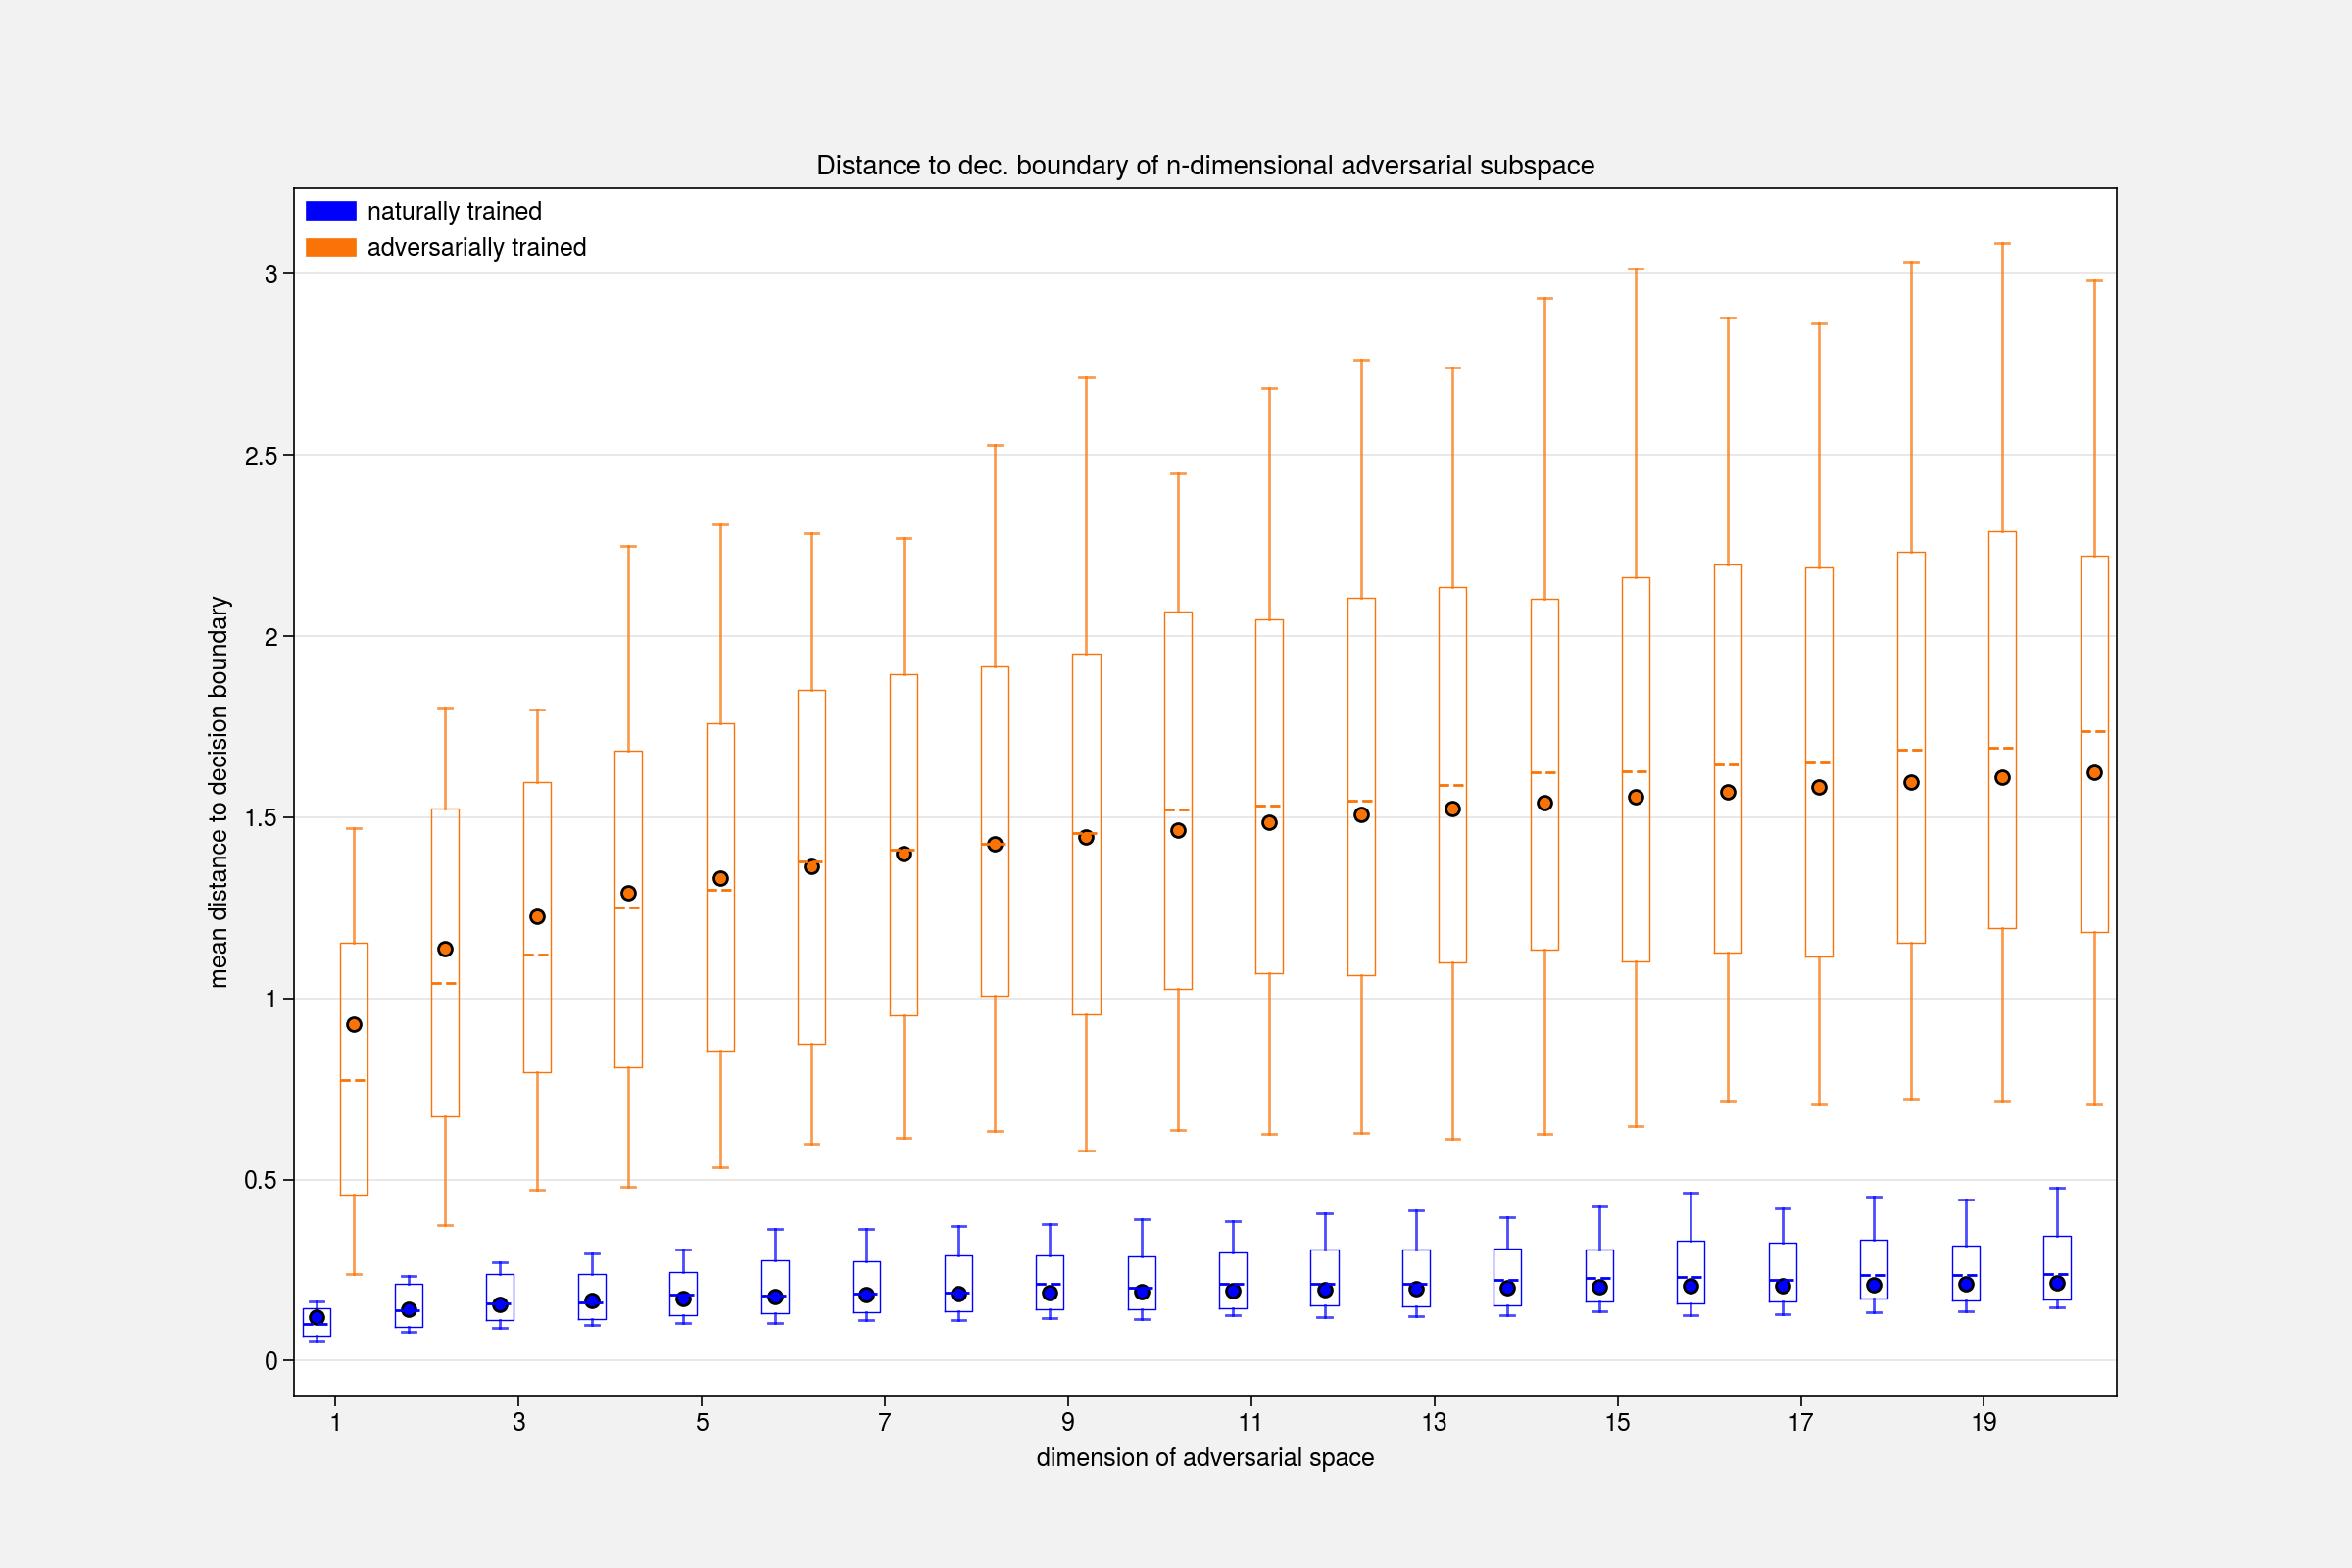

In [8]:
n_dims = 20
mean_dists_natural = np.nanmean(dists_natural,axis=-1)
mean_dists_robust = np.nanmean(dists_robust,axis=-1)

# plot with all adversarials included
fig , ax = plot_boxplot([mean_dists_natural,mean_dists_robust],  n=n_dims, labels=['naturally trained','adversarially trained'])
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(np.arange(0,2*n_dims,2)+0.4,np.nanmean(pert_lengths_madry[:,:n_dims], axis=0),'o',markeredgecolor='k', markerfacecolor='orange', ms=5)
ax.plot(np.arange(0,2*n_dims,2)-0.4,np.nanmean(pert_lengths[:,:n_dims], axis=0),'o',markeredgecolor='k', markerfacecolor='blue', ms=5)
plt.xlabel('dimension of adversarial space')
plt.ylabel('mean distance to decision boundary')
plt.title('Distance to dec. boundary of n-dimensional adversarial subspace')
plt.show()


/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

All-NaN slice encountered

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

All-NaN slice encountered



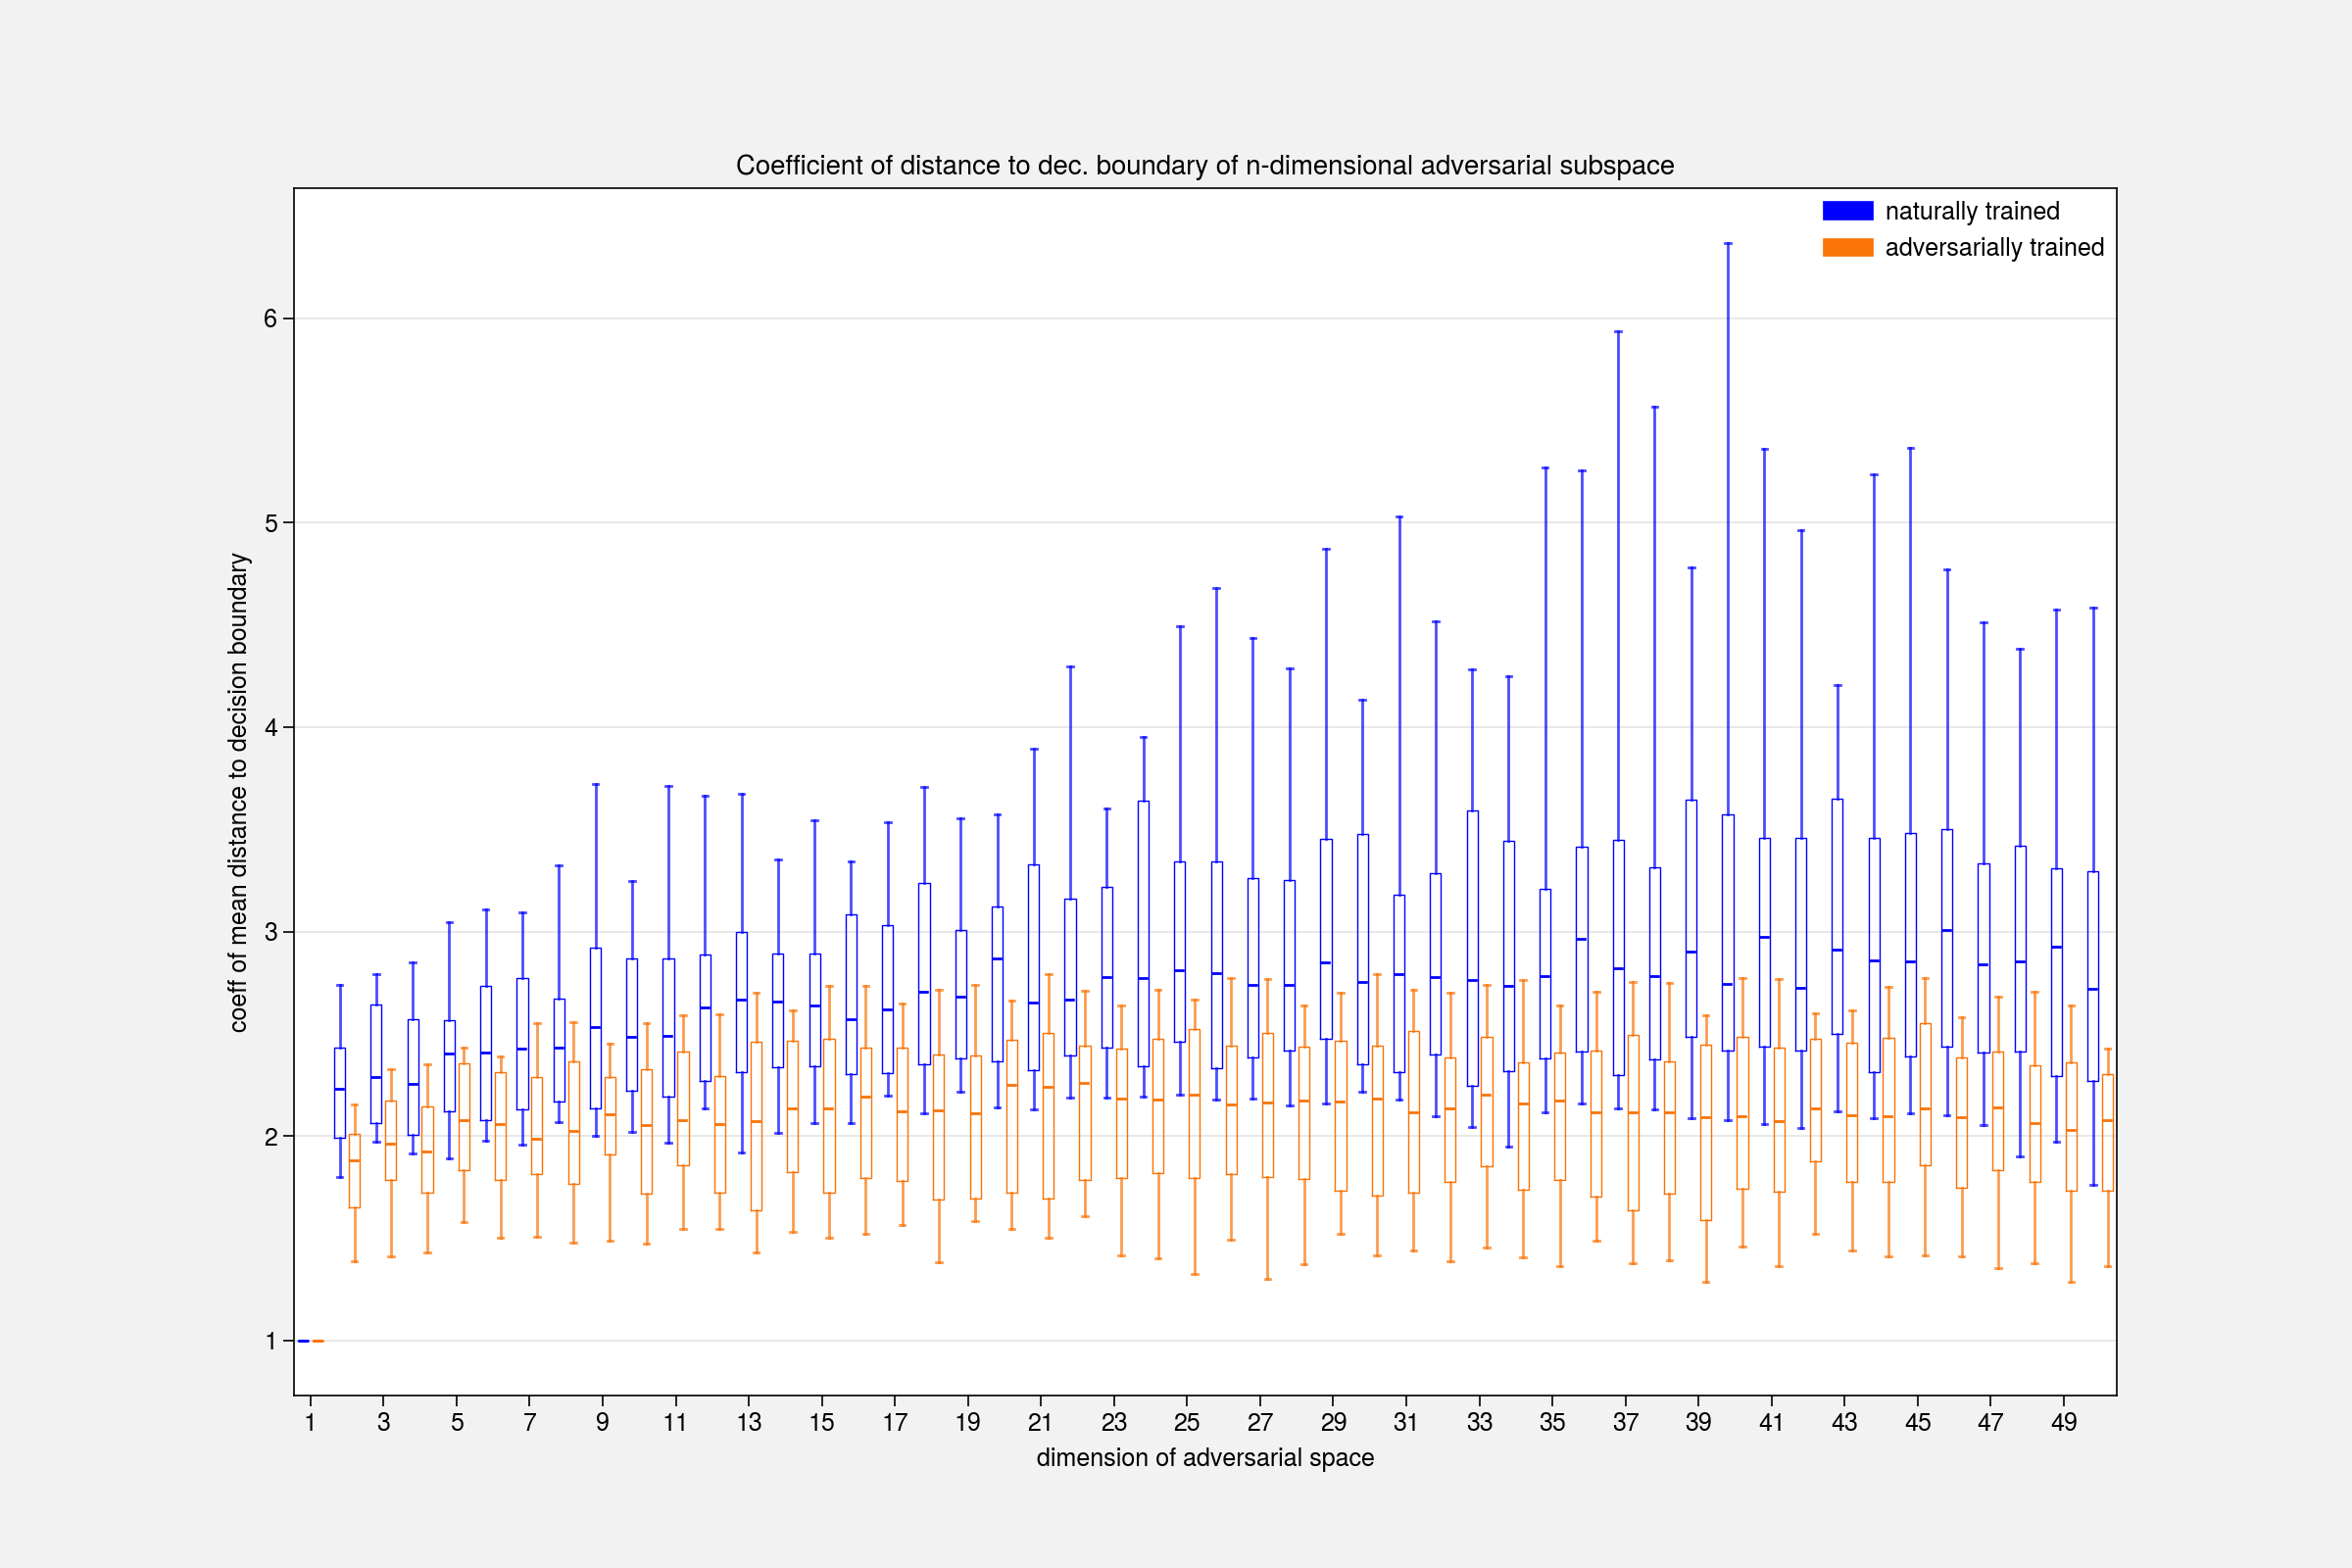

In [10]:
n_dims = 50
max_dists_natural = np.nanmax(dists_natural,axis=-1)
max_dists_robust = np.nanmax(dists_robust,axis=-1)

dist_coeffs_natural = max_dists_natural/pert_lengths
dist_coeffs_robust = max_dists_robust/pert_lengths_madry
fig , ax = plot_boxplot([dist_coeffs_natural,dist_coeffs_robust],  n=n_dims, labels=['naturally trained','adversarially trained'])
fig.set_figheight(8)
fig.set_figwidth(12)
# ax.plot(np.arange(1,n_dims+1),np.nanmean(pert_lengths_madry[:,:n_dims], axis=0),'o', color='orange', ms=15, alpha = .3)
# ax.plot(np.arange(1,n_dims+1),np.nanmean(pert_lengths[:,:n_dims], axis=0),'o', color='blue', ms=15, alpha=.3)
plt.xlabel('dimension of adversarial space')
plt.ylabel('coeff of mean distance to decision boundary')
plt.title('Coefficient of distance to dec. boundary of n-dimensional adversarial subspace')

plt.show()


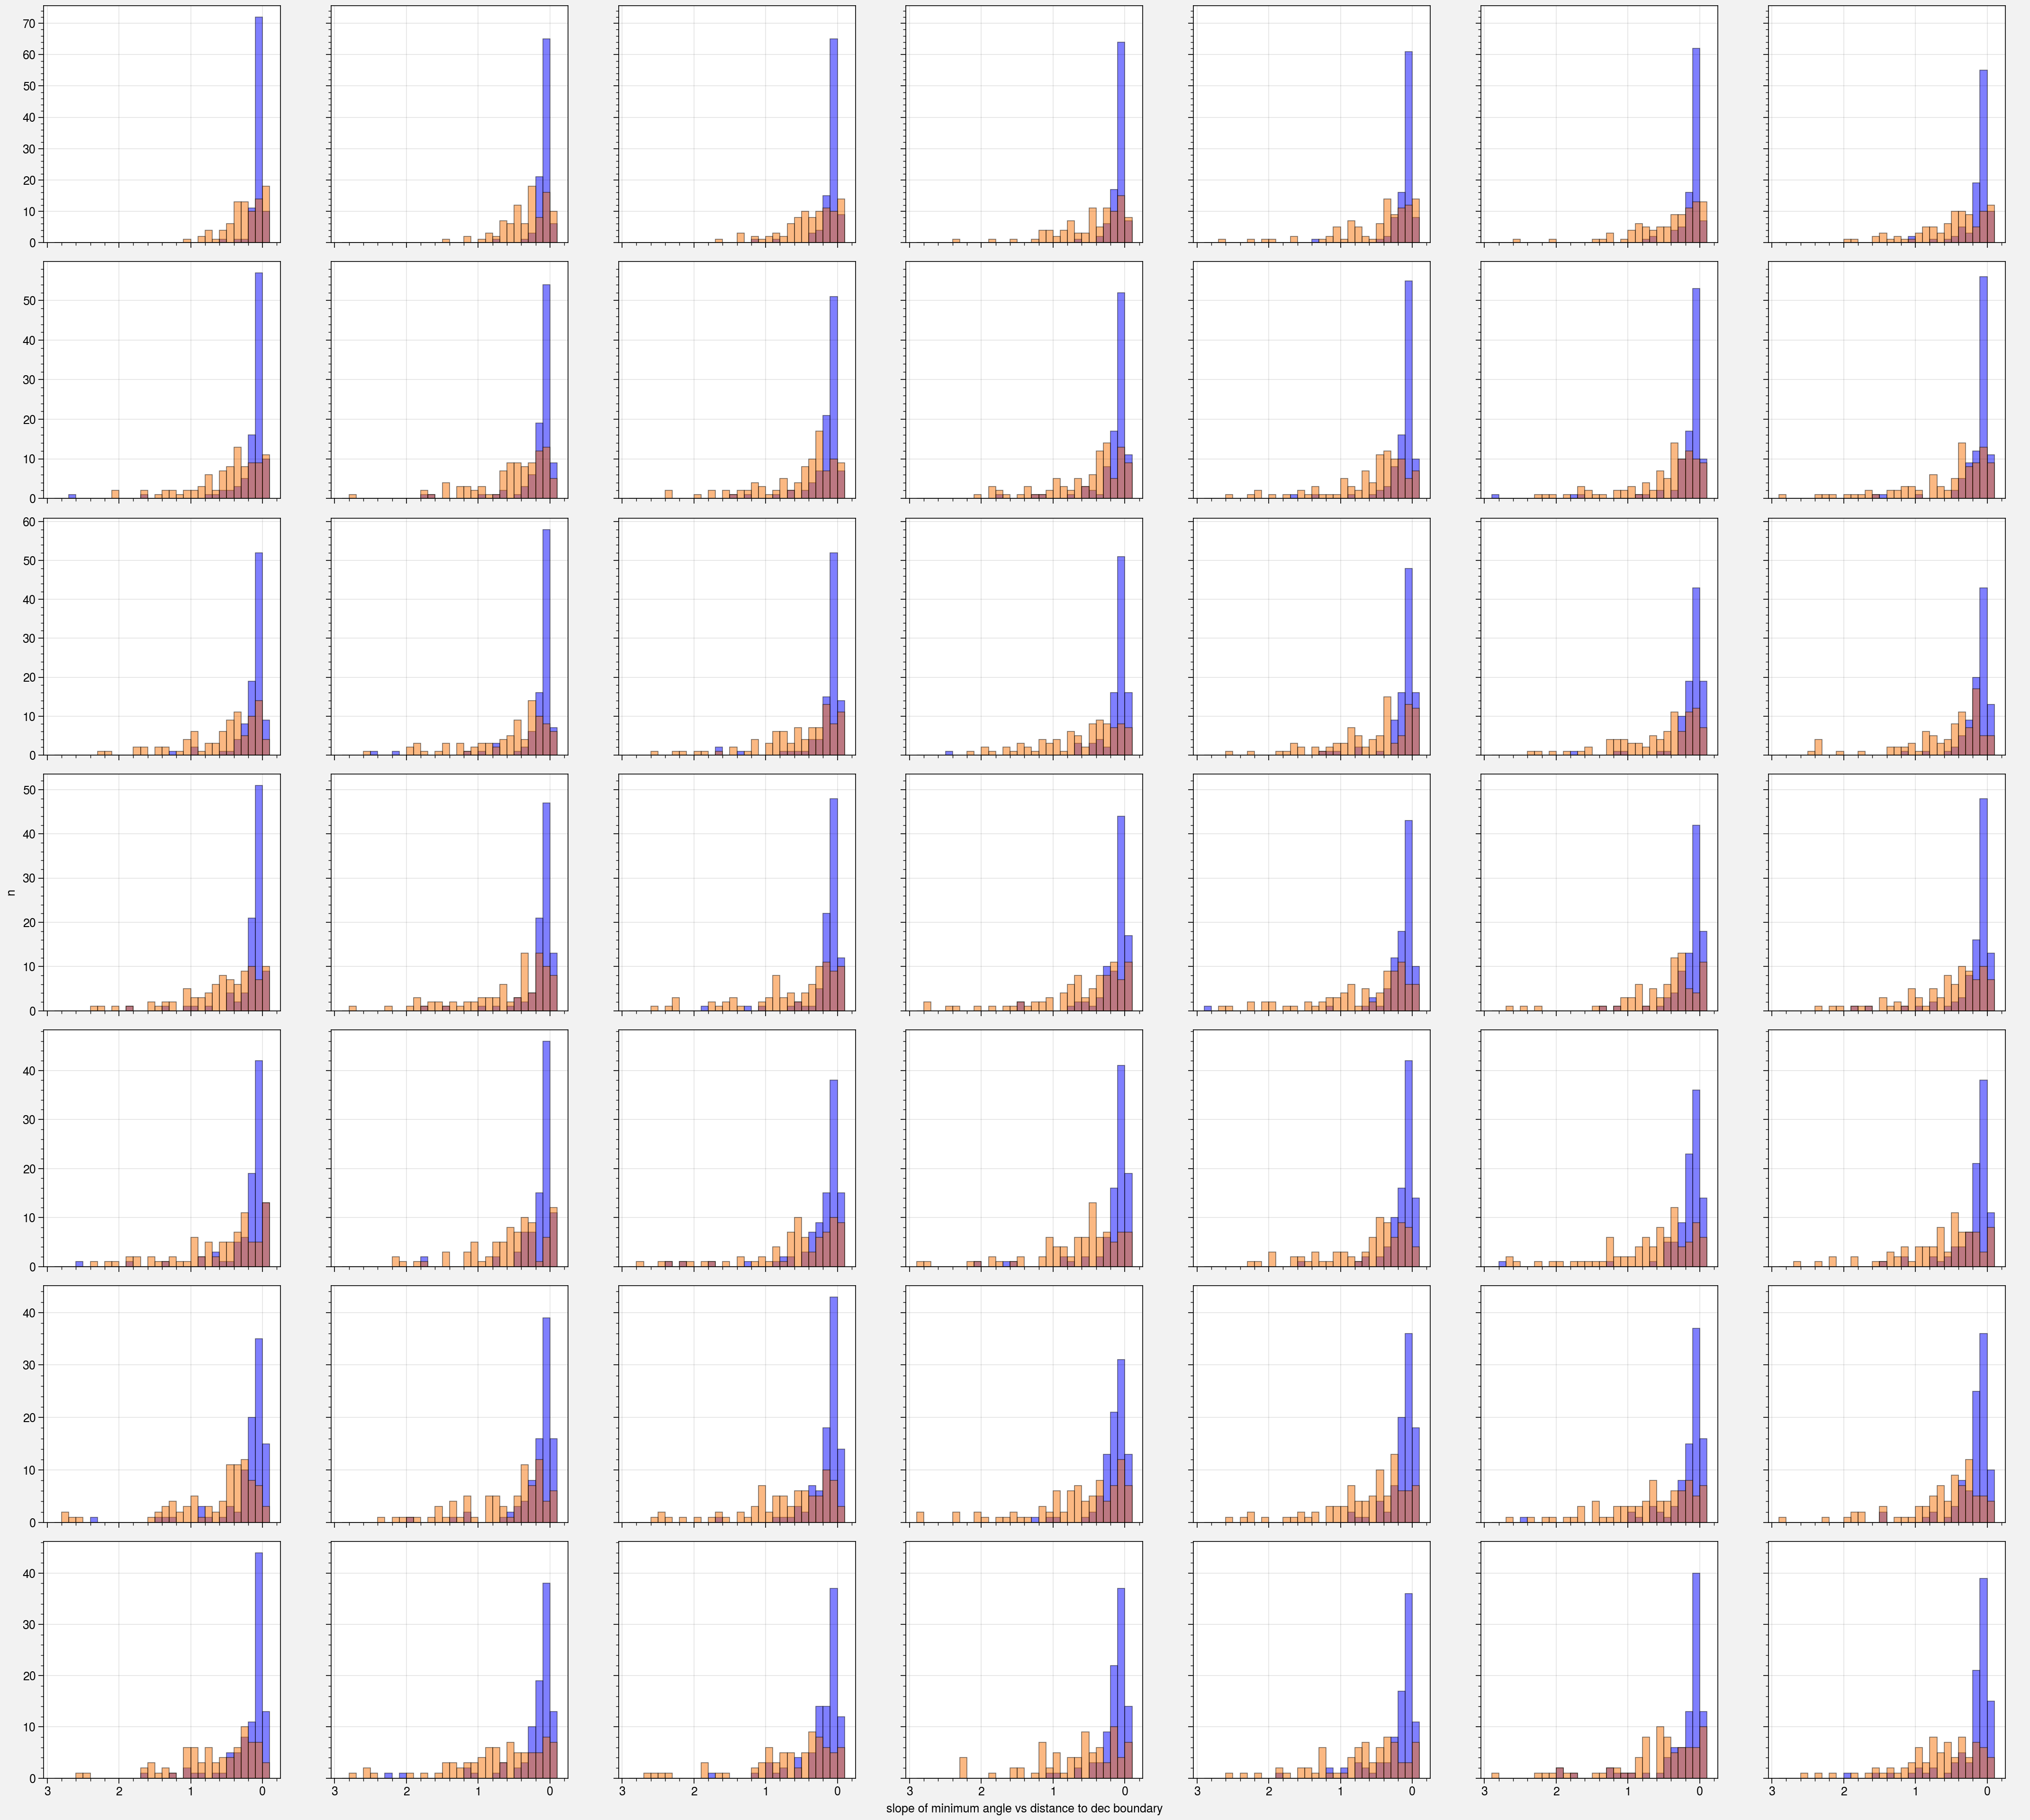

NameError: name 'max_dists_natural' is not defined

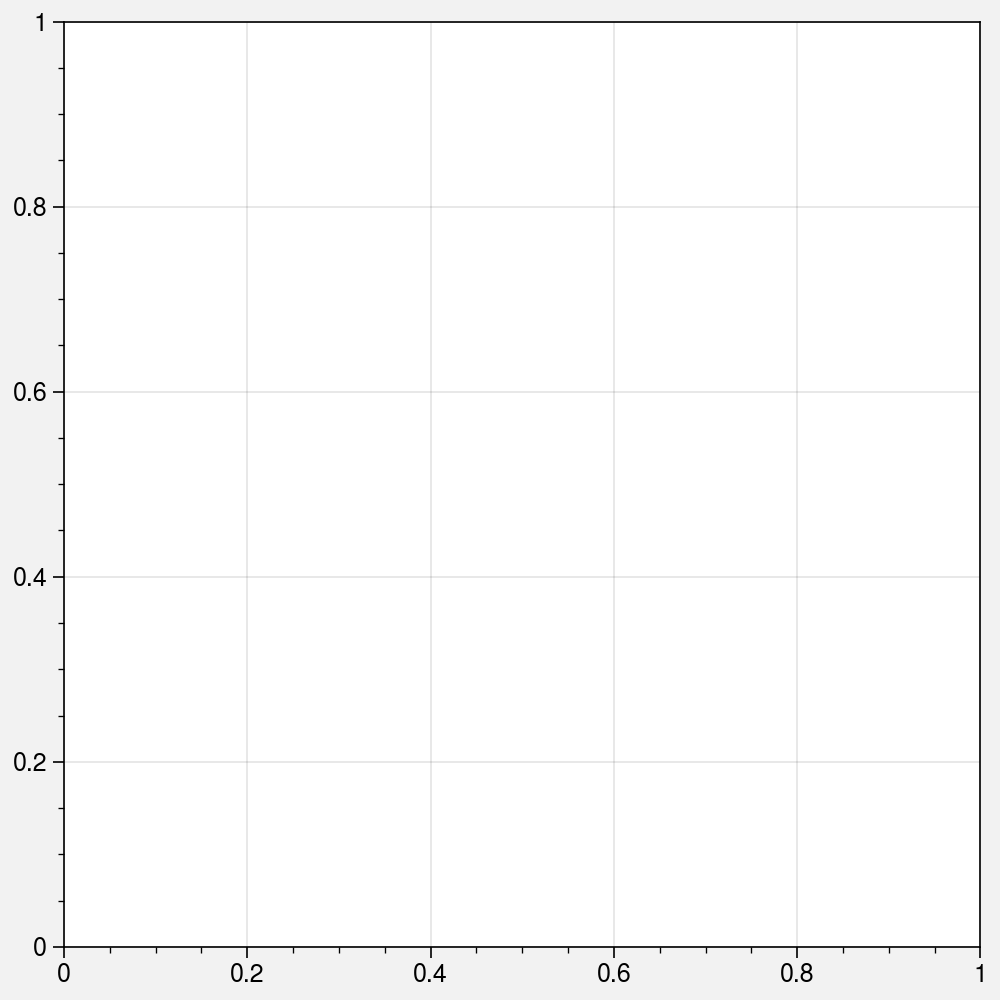

In [9]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
n_cols = 7
n_rows = 7


slopes_natural = np.zeros(dists_natural.shape[:-1])
slopes_robust = np.zeros(dists_natural.shape[:-1])

for img_n in range(len(dists_natural)):
    for dim in range(1,dists_natural.shape[1]):
        if np.all(np.isnan(dists_natural[img_n,dim])):
            slopes_natural[img_n, dim] = np.nan
        else:
            angles_ = angles_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
            dists_ = dists_natural[img_n,dim][np.isfinite(dists_natural[img_n,dim])]
            slopes_natural[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]
        if np.all(np.isnan(dists_robust[img_n,dim])):
            slopes_robust[img_n, dim] = np.nan
        else:
            angles_ = angles_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
            dists_ = dists_robust[img_n,dim][np.isfinite(dists_robust[img_n,dim])]
            slopes_robust[img_n, dim] = np.polyfit(angles_, dists_, deg=1)[0]


fig, axs = pplt.subplots(nrows=n_rows, ncols=n_cols)
axs.format(
    xlabel='slope of minimum angle vs distance to dec boundary', ylabel='n')    
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)            
for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(slopes_natural[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='blue', alpha=.5)
    axs[int(i/n_cols),(i%n_cols)].hist(slopes_robust[:,i+1].flatten(), bins=np.arange(-0.1,3,.1), color='orange', alpha=.5)
#     axs[int(i/n_cols),(i%n_cols)].invert_xaxis()
plt.show()


n_dims=2
col_range = np.linspace(0,1,n_dims, endpoint=True)
cmap=plt.get_cmap('viridis')
colors = [cmap(x) for x in col_range]
fig, ax = pplt.subplots(figsize=(5,5))
for dim in range(n_dims):
    ax.scatter(slopes_natural[:,dim], max_dists_natural[:,dim], s=60, color=colors[dim], alpha=.8)
# plt.ylim(-.01,.4)
# plt.xlim(-.01,.4)
plt.colorbar(cmap)
plt.ylabel('Max. distance to decision boundary')
plt.xlabel('Slope of angles-distance')
plt.show()



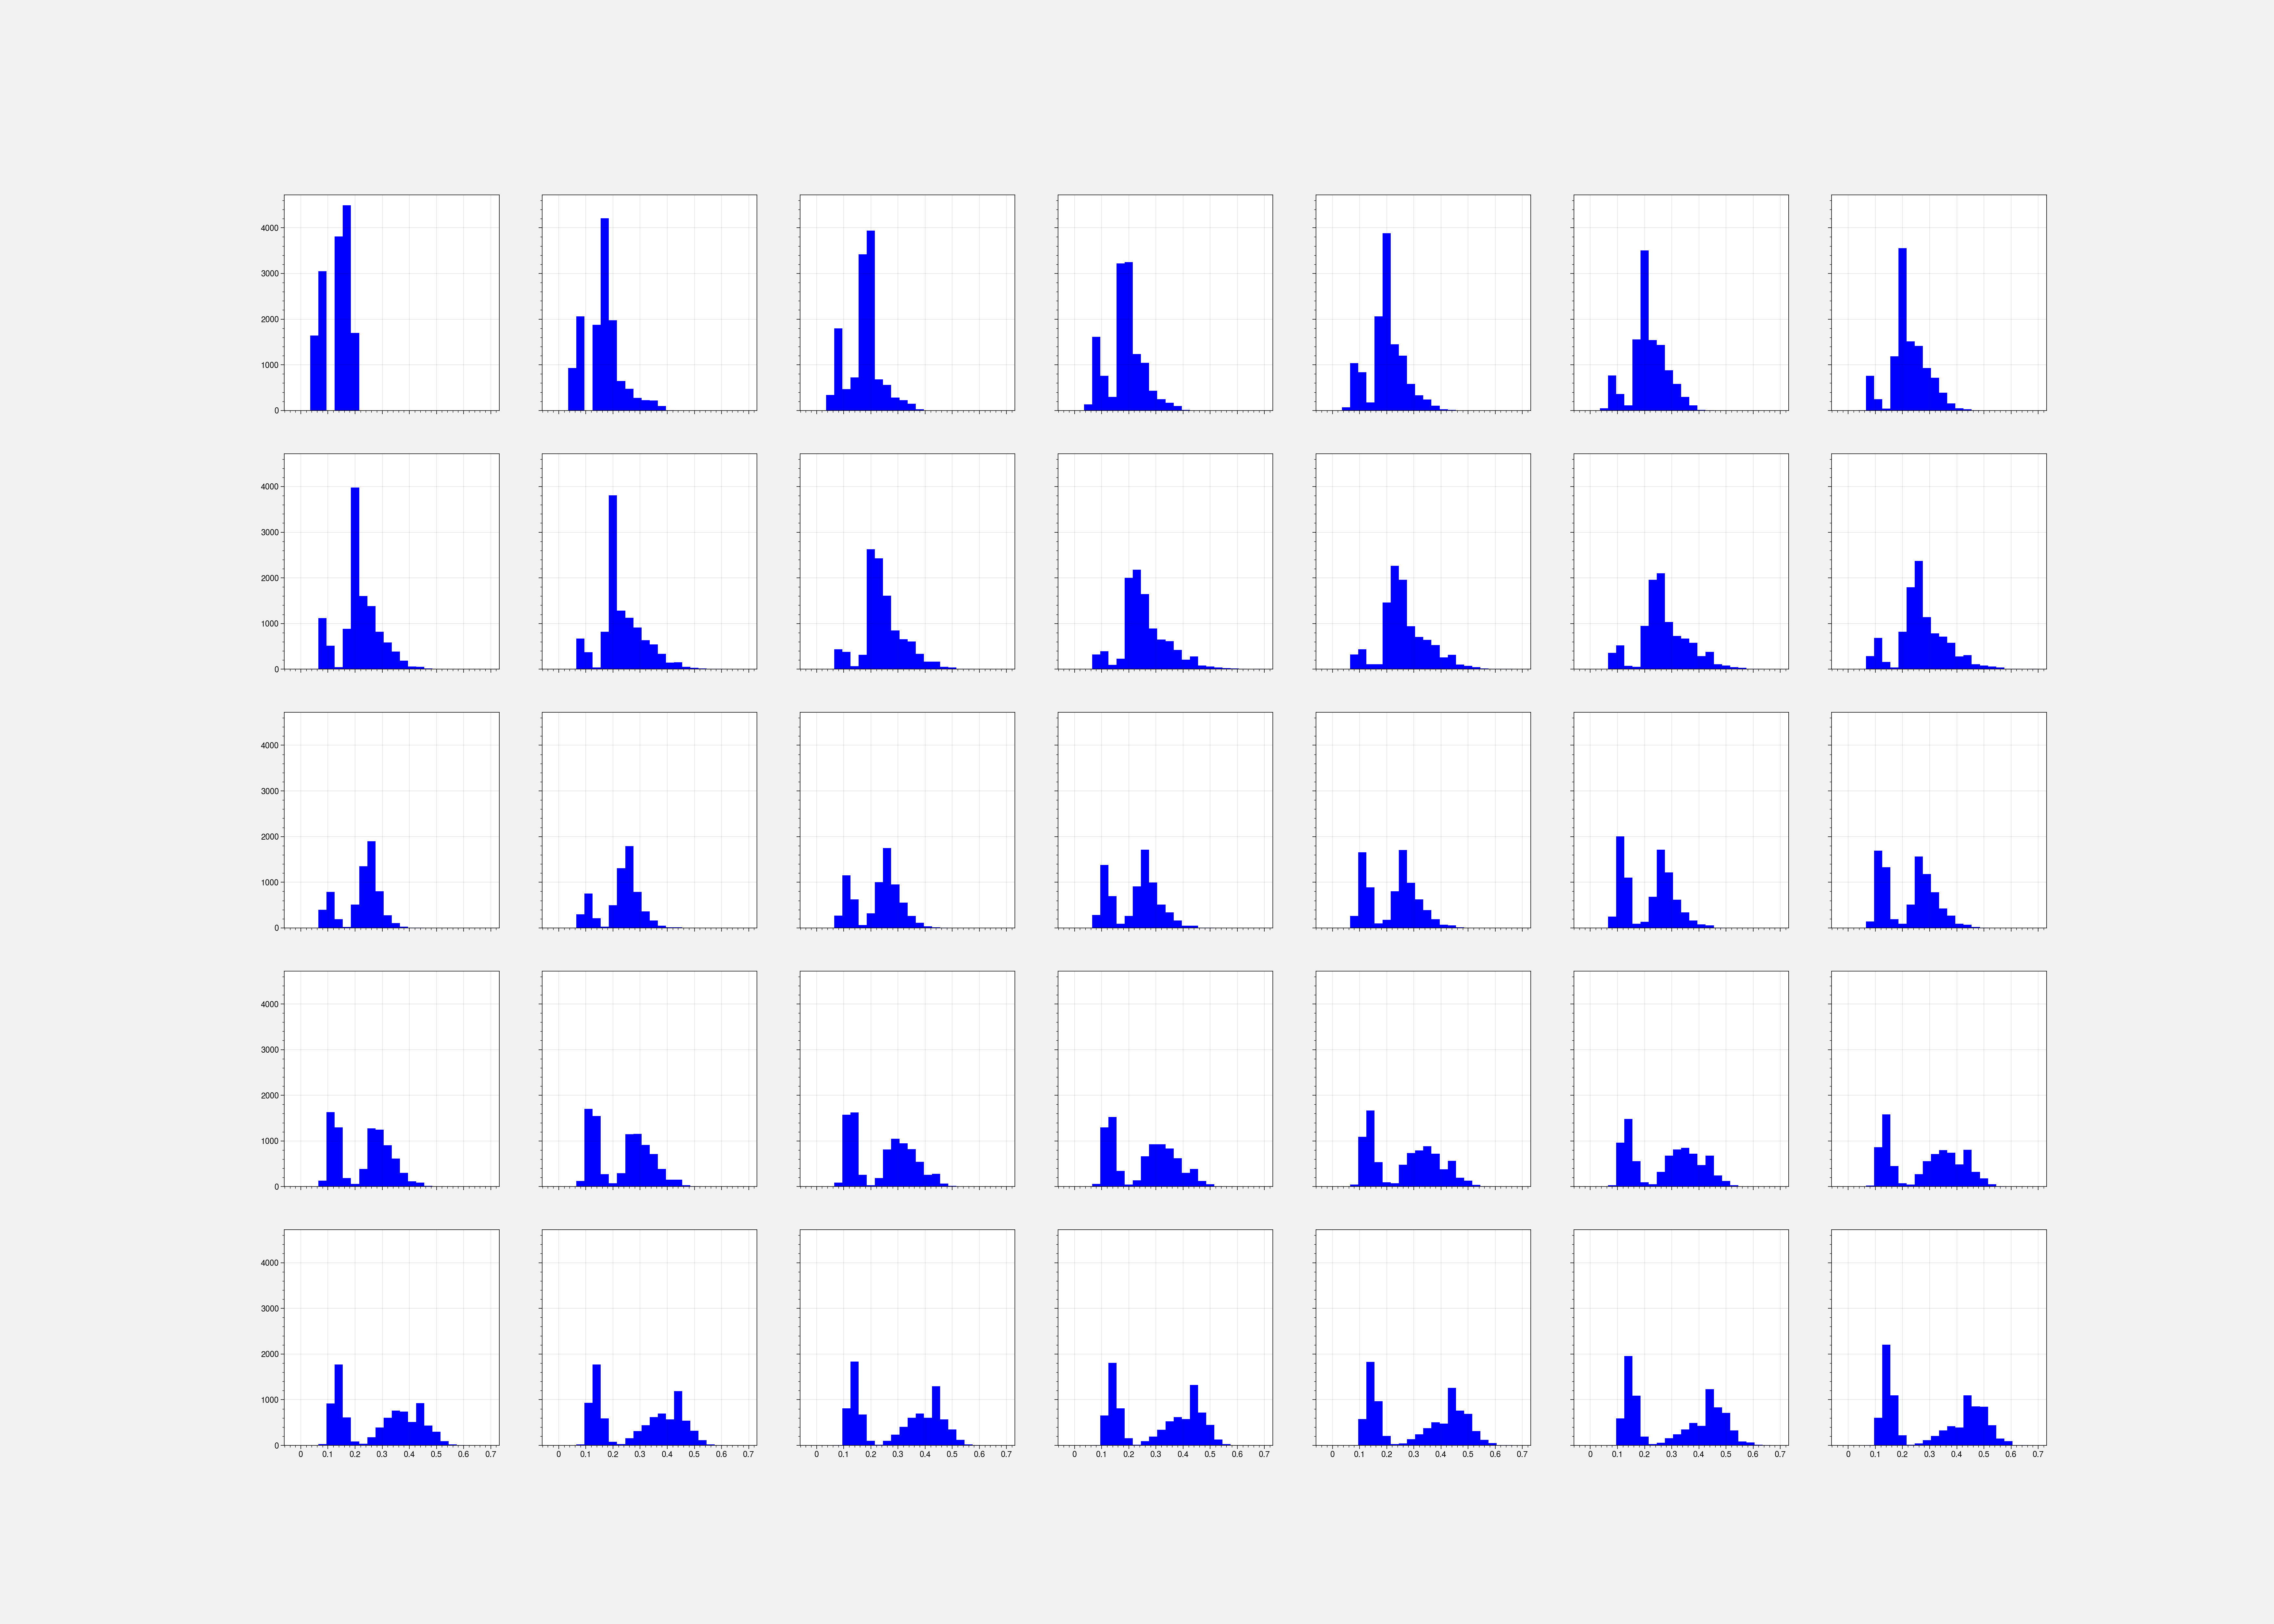

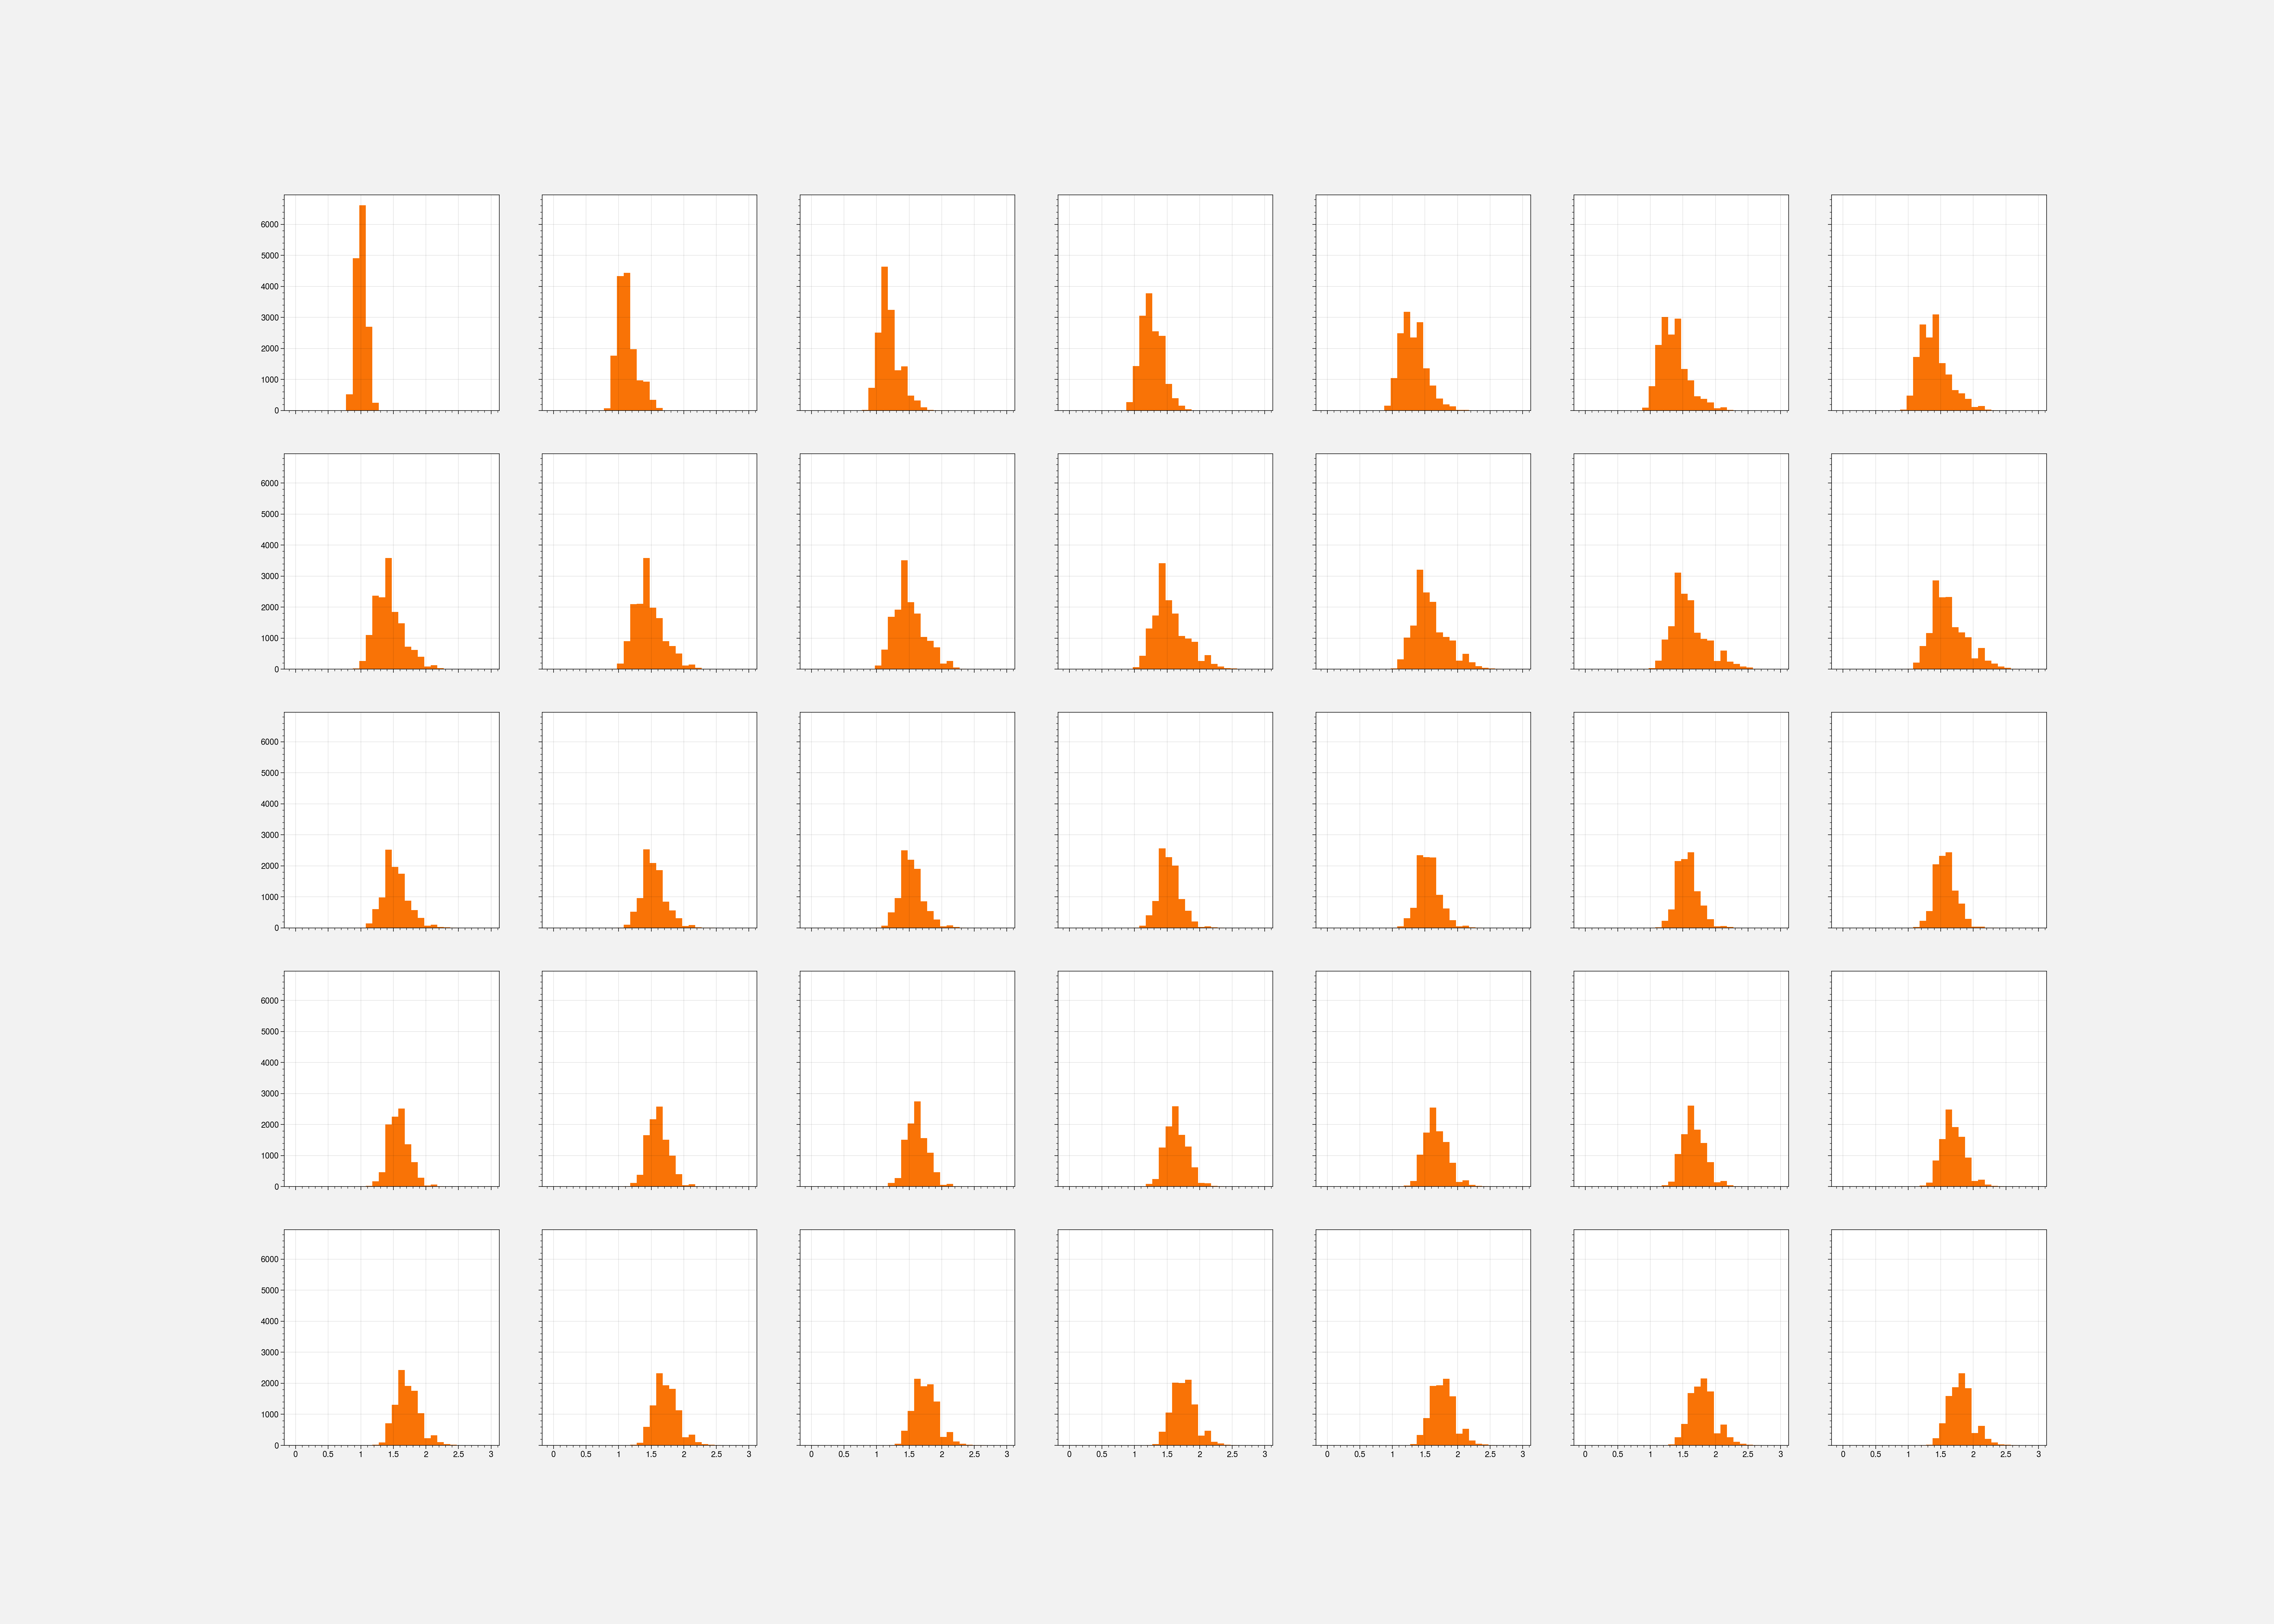

In [9]:
n_cols = 7
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*5,), sharex=True, sharey=True)

for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(dists_natural[:,i+1].flatten(), bins=np.arange(-0.025,.7,.03), color='blue')
    

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*5,), sharex=True, sharey=True)

for i in range(n_rows*n_cols):
    axs[int(i/n_cols),(i%n_cols)].hist(dists_robust[:,i+1].flatten(), bins=np.arange(-0.025,3,.1), color='orange')

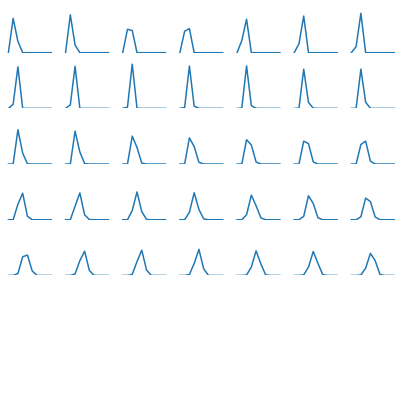

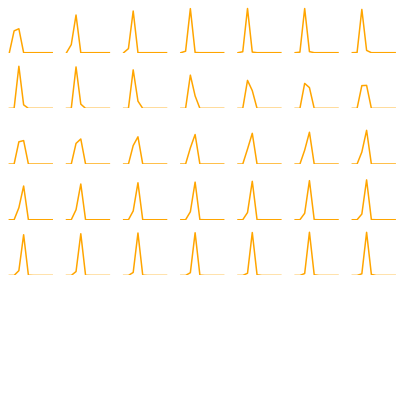

In [26]:
n_cols = 7
n_rows = 7

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
bins = np.arange(-0.025,1,.1)
for i in range(n_rows*n_cols):
#     sns.kdeplot(x=dists_natural[:,i+1].flatten(), bw_method='scott', ax = axs[int(i/n_cols),(i%n_cols)])
    sns.histplot(x=dists_natural[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False)
plt.xlim(0,1)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
bins = np.arange(-0.025,5,.5)
for i in range(n_rows*n_cols):
#     sns.kdeplot(x=dists_robust[:,i+1].flatten(), bw_method='scott', ax = axs[int(i/n_cols),(i%n_cols)], color='orange')
    sns.histplot(x=dists_robust[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False, color='orange')
plt.xlim(0,5)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

Mean of empty slice



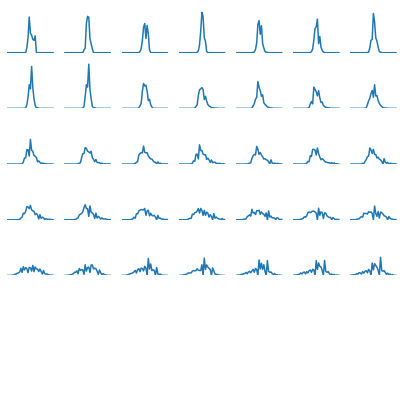

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:

Mean of empty slice



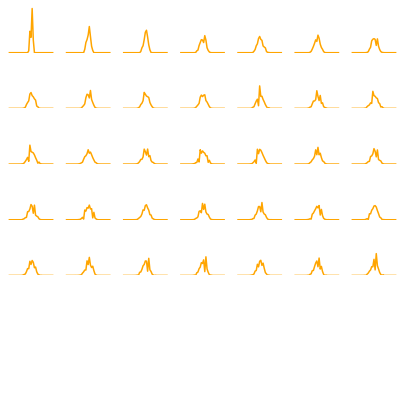

In [31]:
n_cols = 7
n_rows = 7
n_dims=50
bins = np.arange(-0.2,0.2,0.01)
hist_data = dists_natural-np.nanmean(dists_natural,axis=-1,keepdims=True)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
for i in range(n_rows*n_cols):
#     hist = np.histogram(hist_data[:,i+1].flatten(), bins=bins)[0]
#     axs[int(i/n_cols),(i%n_cols)].hist(hist_data[:,i+1].flatten(), bins=bins)
    sns.histplot(x=hist_data[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False)
plt.xlim(-.2,.2)
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

bins = np.arange(-1,1,0.05)
hist_data = dists_robust-np.nanmean(dists_robust,axis=-1,keepdims=True)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows,), sharex=True, sharey=True)
for i in range(n_rows*n_cols):
    sns.histplot(x=hist_data[:,i+1].flatten(), bins=bins, stat='density', ax = axs[int(i/n_cols),(i%n_cols)], element='poly', fill=False, color='orange')
[axi.set_axis_off() for axi in axs.ravel()]
plt.show()

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning:

Mean of empty slice

/home/bethge/dschultheiss/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning:

Degrees of freedom <= 0 for slice.



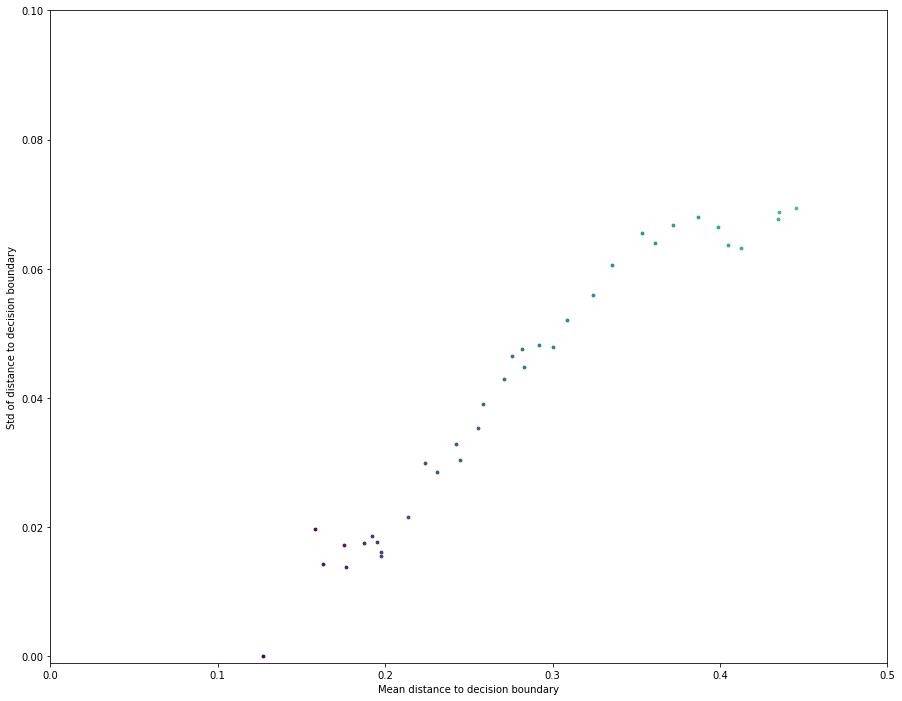

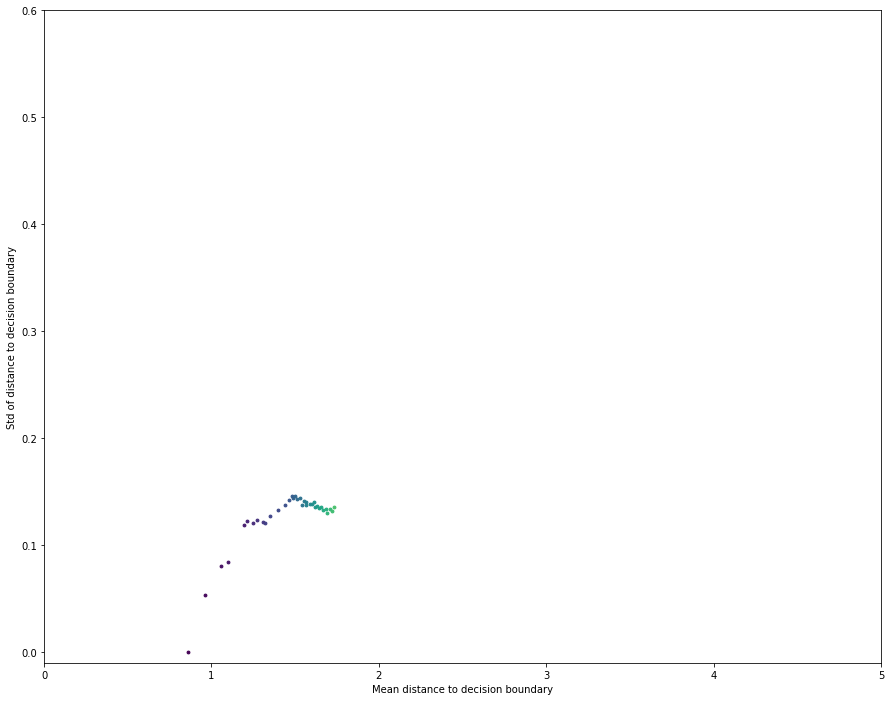

In [32]:
mean_natural = np.nanmean(dists_natural,axis=-1)
mean_robust = np.nanmean(dists_robust,axis=-1)

std_natural = np.nanstd(dists_natural, axis=-1)
std_robust = np.nanstd(dists_robust, axis=-1)

n_dims = 50
col_range = np.linspace(0,1,n_dims, endpoint=True)
cmap=plt.get_cmap('viridis')
colors = [cmap(x) for x in col_range]

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_natural[:,dim], std_natural[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.001,.1)
plt.xlim(0,.5)
plt.show()

plt.figure(figsize=(15,12))
for dim in range(n_dims):
    plt.scatter(mean_robust[:,dim], std_robust[:,dim], s=8, color=colors[dim])
plt.xlabel('Mean distance to decision boundary')
plt.ylabel('Std of distance to decision boundary')
plt.ylim(-.01,.6)
plt.xlim(0,5)
plt.show()

Text(0, 0.5, 'rate of out of bounds samples')

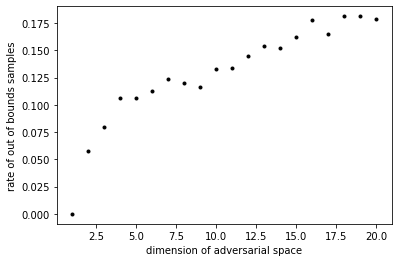

In [50]:
plt.plot(np.arange(1,n_dims+1),np.mean(np.isnan(dists_robust[:8,:n_dims]).sum(-1),axis=0)/dists_robust.shape[-1],'k.')
plt.xlabel('dimension of adversarial space')
plt.ylabel('rate of out of bounds samples')

# Decision Space Visualization

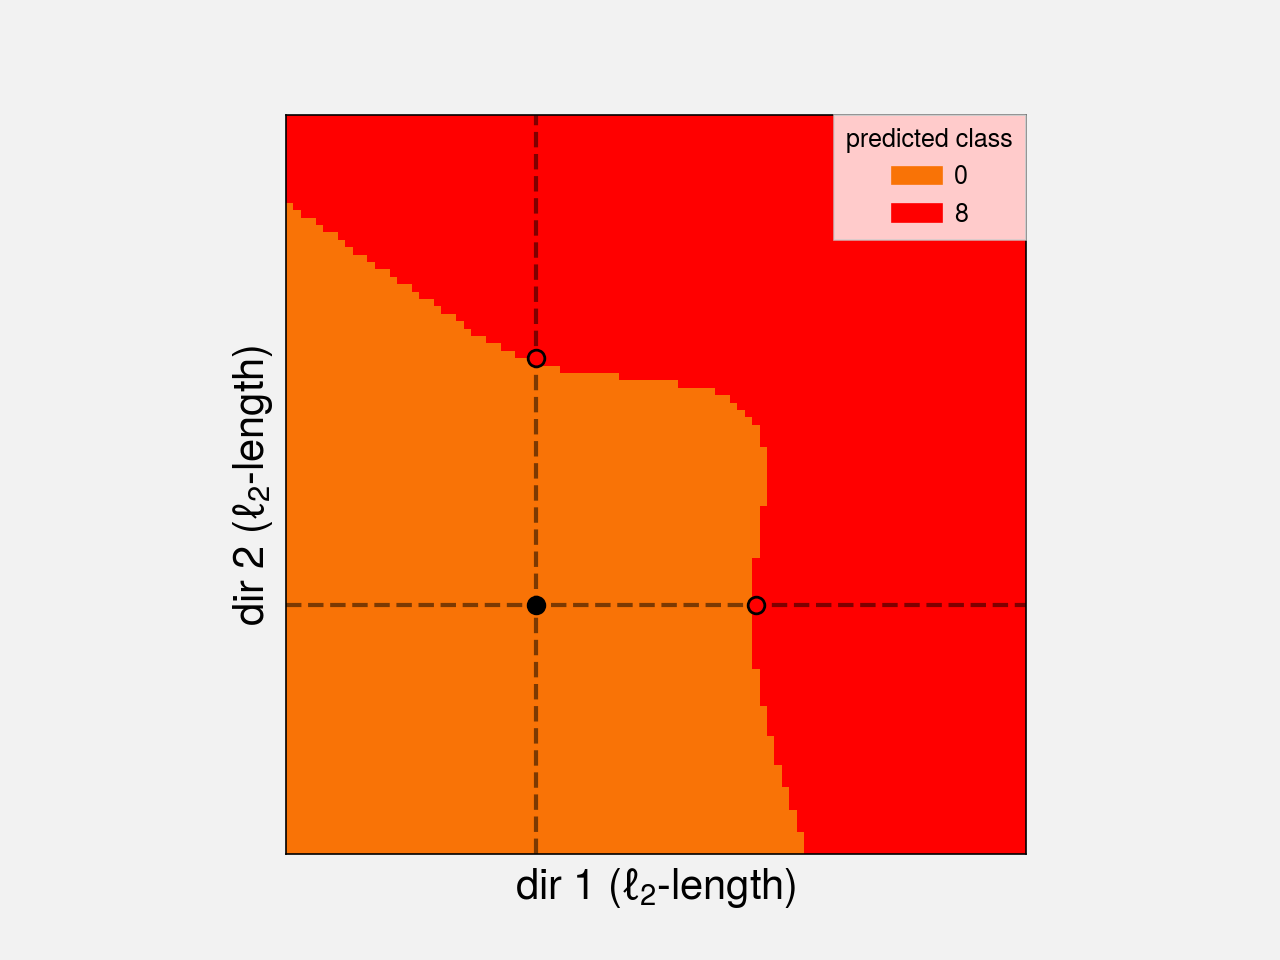

In [81]:
n_rows = 1
n_cols = 1
# fig, axs = plt.subplots(n_rows,n_cols)
# fig2 = plt.figure()
# fig2.axes.append(ax)
for i, img_n in enumerate([0]):
#     img_n = img_n[0]
    orig = images[img_n]
    adv1 = advs[img_n,0]
    adv2 = advs[img_n,1]
    model_ = model_natural
    axs = pl.plot_dec_space(orig, adv1, adv2, model_,n_grid=100, offset=.1, len_grid=2, show_legend=True, show_advs=True, overlay_inbounds=True)#, ax = axs[int(i/n_cols),(i%n_cols)])
    fig.set_figheight(10)
    fig.set_figwidth(30)
    axs.set_xticks([])
    axs.set_yticks([])
plt.show()

# Accuracy table

In [46]:
epsilons = [0,0.1,0.25,.5,1,2]
n_dims = 10
all_accs = [epsilons]
n_nat = len(pert_lengths)
n_rob = len(pert_lengths_madry)

for d in range(n_dims):
    pl_nat = pert_lengths[:,d]
    pl_rob = pert_lengths_madry[:,d]
    accs= np.zeros((len(epsilons),2))
    for i, e in enumerate(epsilons):
        accs[i,0] = .9525 - ((pl_nat<=e).sum()/n_nat*.9525)
        accs[i,1] = .9083 - ((pl_rob<=e).sum()/n_rob*.9083)   
    accs=np.around(accs*100,2)
    all_accs.append([str(a[0]) + '% / '+ str(a[1]) + '%' for a in accs])

In [87]:
head = ['$\epsilon$']
head = head + [e for e in np.arange(1,n_dims+1)]
widths = [40]
widths = widths + [100 for e in range(n_dims)]

fig = go.Figure(data=[go.Table(columnwidth=widths,
                         header=dict(
                             values=head
                             ),
                         cells=dict(
                             values = all_accs,
                             fill_color = ['rgb(189, 215, 231)'] + ['lightgrey' for e in range(n_dims)] ,
                             ))
                             ])
fig.show()